In [5]:
from fit_completeness_to_catalog import *
import os
name = "sullivan"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selected 907 stars


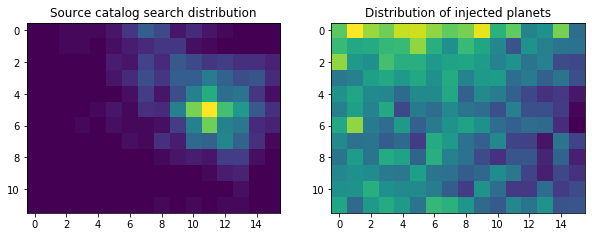

Injected 12399 transiting planets


In [21]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 200000
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

In [22]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)
_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [ 5.67567551e-03 -1.41666727e-02  6.82528706e-05  1.48836520e-02
  4.61643169e-02  6.55981577e-01  1.48043978e+00  3.06427019e-01]
Set initial condition


In [23]:
i = 0
while True:
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        sampler.run_mcmc(p0, 1000, store=True)
        print(i)
        i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
emcee: Exception while calling your likelihood function:
  params: [-4.08532902e-04 -4.53863993e-03  4.61694352e-03  3.05655311e-02
  8.34366477e-01  6.13702475e-01  5.37618843e-01  3.92472323e-01]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "<ipython-input-23-d28c7bf780a4>", line 4, in <module>
    print(sampler.get_autocorr_time())
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 526, in get_autocorr_time
    return self.backend.get_autocorr_time(**kwargs)
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/backends/backend.py", line 150, in get_autocorr_time
    return thin * autocorr.integrated_time(x, **kwargs)
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py", line 110, in integrated_time
    raise AutocorrError(tau_est, msg)
emcee.autocorr.AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2460;
tau: [10668.0786985    819.81782831   527.07837429 10048.68983438
  9617.08558559 14829.70717439 12932.29498548 12029.2703992 ]

During handling of the above exceptio

KeyboardInterrupt: 

In [24]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2478;
tau: [10765.58342657   818.38780052   527.51195293 10146.81698464
  9637.35057694 14992.86404633 13044.8587584  12162.50164028]

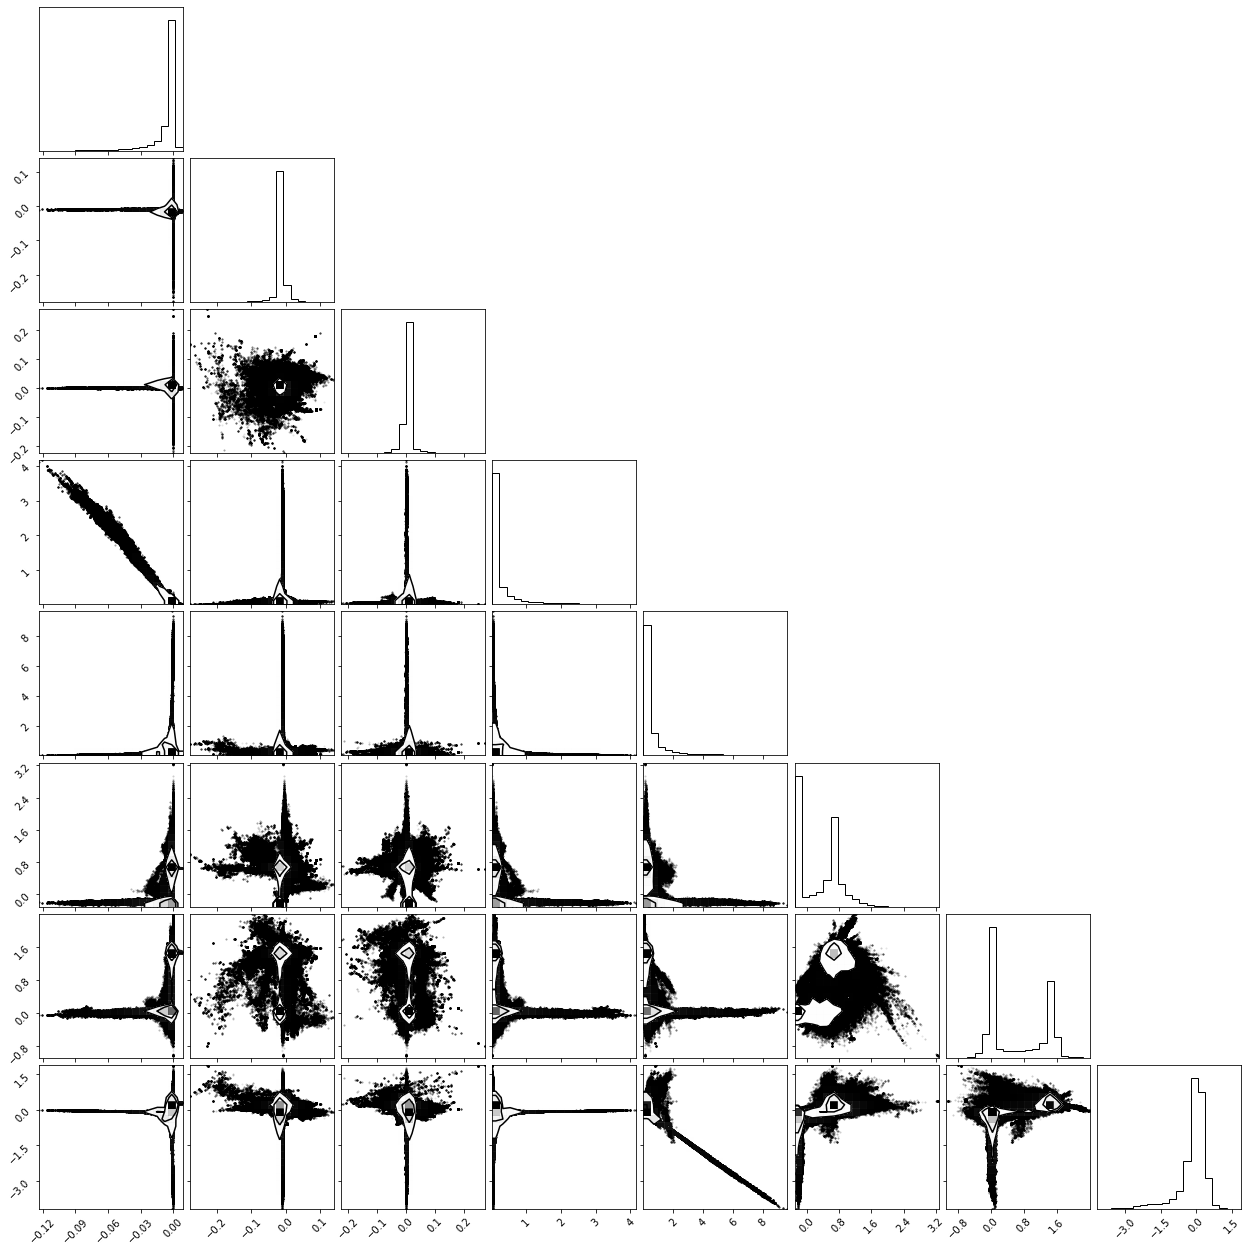

In [25]:
_ = corner.corner(sampler.flatchain) # check autocorrelation times

In [26]:
ll(np.mean(sampler.flatchain,axis=0))

-4748.0087379818215

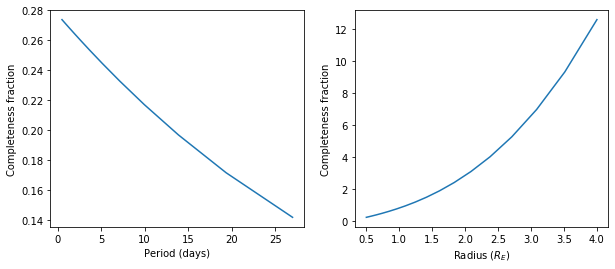

In [27]:
params = np.mean(sampler.flatchain, axis=0)
plot_marginalized_comps(params)
# cut off days at 27, or at 90th percentile for TOIs

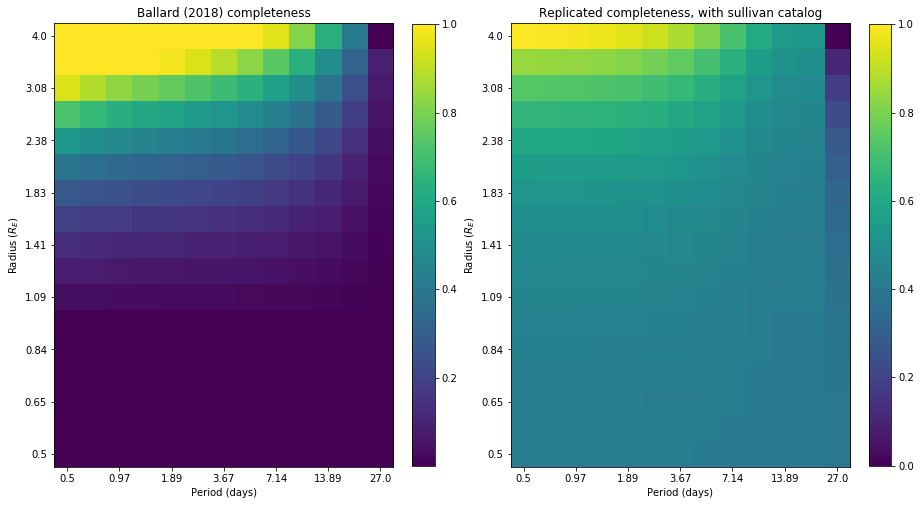

In [28]:
repcomp = np.outer(comp_poly(bins_p, *params[:4]), comp_poly(bins_r, *params[4:])).T
repcomp -= np.min(repcomp)
repcomp /= np.max(repcomp)
plot_overall_comps(repcomp, name)